# Exercises week 43 and 44
### The OR, AND, and XOR gates

We have two input values $x_1$ and $x_2$ which decide the output from the two types of gates. Since each input value can be either 0 or 1 we can write the input as a design matrix $X$ where the first and second column represents $x_1$ and $x_2$ respectively as:
$$X = \begin{bmatrix} 0 & 0 \\ 0 & 1 \\ 1 & 0 \\ 1 & 1 \end{bmatrix}$$

The output $y$ for the different gates we can write as the vectors $y^T=[0, 1,1,1]$ for the OR gate, $y^T=[0,0,0,1]$ for the AND gate, and $y^T=[0, 1, 1, 0]$ for the XOR gate. We setup this matrix and these vectors:


In [271]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # heatmap plots
import jax.numpy as jnp
from jax import grad  # automatic differentiation
from sklearn.metrics import accuracy_score 

# Set up design matrix and output vectors
X = np.asarray([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

# Gate target arrays
yOR = np.asarray([0, 1, 1, 1]).reshape(-1, 1)
yAND = np.asarray([0, 0, 0, 1]).reshape(-1, 1)
yXOR = np.asarray([0, 1, 1, 0]).reshape(-1, 1)

We create our NN architecture with the Sigmoid function $\sigma$ as activation function where
\begin{equation}
    \sigma(x) = \frac{1}{1+e^{-x}}
\end{equation}
as such

In [272]:
# Parameters
n_hidden_nodes = 2  # hidden nodes per layer
n_categories = 1  # output nodes
n_inputs, n_features = X.shape  # 2 inputs, 4 features
target_gate = "OR"  # choose which target gate to train on


# Activation function 
def activation(x):
    # Use sigmoid function:
    return 1 / (1 + np.exp(-x))


# Initialize random number generator with seed
rng = np.random.default_rng(2023)

# Weights and bias in the hidden layer
hidden_weights = rng.standard_normal((n_features, n_hidden_nodes))  # weights normally distributed
hidden_bias = np.zeros(n_hidden_nodes) + 0.01

# Weights and bias in the output layer
output_weights = rng.standard_normal((n_hidden_nodes, n_categories))  # weights normally distributed
output_bias = np.zeros(n_categories) + 0.01

print("Before back propagation:\n")
print("Output weights and bias:")
print(output_weights)
print(output_bias)

print()
print("Hidden weights and bias:")
print(hidden_weights)
print(hidden_bias)

Before back propagation:

Output weights and bias:
[[-0.77586755]
 [ 0.8087058 ]]
[0.01]

Hidden weights and bias:
[[ 0.60172129  1.15161897]
 [-1.35946236  0.22205533]]
[0.01 0.01]


### Feed forward
Then we set up the feed forward algorithm and compare one pass with the target vectors $y^T$

In [273]:
# Get the chosen target array
if target_gate == "OR":
    target = yOR
elif target_gate == "AND":
    target = yAND
elif target_gate == "XOR":
    target = yXOR
else:
    raise ValueError(f"Target gate not found, got '{target_gate}'.")

In [274]:
def feed_forward(X):
    """Feed forward algorithm for one hidden layer"""
    # Weighted sum of inputs to the hidden layer
    z_h = X @ hidden_weights + hidden_bias

    # Activation in the hidden layer
    a_h = activation(z_h)

    # Weighted sum of inputs to the output layer
    z_o = a_h @ output_weights + output_bias

    # Activation of output layer; contains the output probabilities
    probabilities = activation(z_o)  # this is a_o
    return a_h, probabilities


@np.vectorize
def predict(probability):
    """Get prediction from array with floats. Step function."""
    if not isinstance(probability, (int, float)):
        raise ValueError(f"Probability must be a number, int or float. Got {type(probability)}")
    if probability < 0.5:
        return 0
    else:
        return 1


# Make prediction and compare with gate target y_vectors
a_h, probabilities = feed_forward(X)
predictions = predict(probabilities)

print("Target:")
print(target)

print("\nProbabilities:")
print(probabilities)

print("\nPrediction:")
print(predictions)

Target:
[[0]
 [1]
 [1]
 [1]]

Probabilities:
[[0.50662492]
 [0.5747513 ]
 [0.53068917]
 [0.60044713]]

Prediction:
[[1]
 [1]
 [1]
 [1]]


We see this prediction does not match any target. This is because we only did one pass and that was with random starting weights. Now we setup the cost function and the back propagation algorithm.


<!-- 
For the cost function we use the cross entropy for binary classification given as
$$C(\boldsymbol{\theta}) = -\sum_{i=1}^n \left( y_i \ln [p(y_i | x_i, \boldsymbol{\theta)}] + (1-y_i)\ln[1-p(y_i | x_i, \boldsymbol{\theta)}] \right)$$

where the probabilities $p$ we have from the sigmoid function 
$$p(y_i=1|x_i, \boldsymbol{\theta}) = \frac{\exp(\theta_0 + \theta_1 x_i)}{1- \exp(\theta_0 + \theta_1 x_i)}$$
$$p(y_i=0|x_i, \boldsymbol{\theta}) = 1 - p(y_i=1|x_i, \boldsymbol{\theta})$$ 
-->
### Cost function

For the cost function we use the cross entropy for binary classification given as
\begin{equation}
    C(\boldsymbol{W}) = -\sum_{i=1}^n \left( t_i \log a_i^L + (1-t_i)\log(1-a_i^L) \right)
\end{equation}

where $t$ is the target and $a^L$ is the final activation from the final/output layer, expressed for a general layer $l$ as:
\begin{equation*}
    a_i^l = \sigma(z_i^l)
\end{equation*}

and $z^L$ is the weighted sum of inputs to the output layer, expressed for a general layer $l$ as:

\begin{equation*}
    z_i^l = \sum_j w_{ij}^l a_j^{l-1} + b_i^l
\end{equation*}

or in matrix notification:

\begin{equation}
    \mathbf{a}^l = \sigma(\mathbf{z}^l)
\end{equation}

\begin{equation}
    \mathbf{z}^l = \mathbf{W}^l \mathbf{a}^{l-1} + \mathbf{b}^l
\end{equation}

for the first layer $l=1$ we have the input layer $a^0$ which is just the input design matrix $X$:
\begin{equation}
    \mathbf{z}^{l=1} = \mathbf{W}^{l=1} \mathbf{X} + \mathbf{b}^{l=1}
\end{equation}

In [275]:
def cost_log_reg(target):
    """Returns a function for the logistic cross entropy for binary classification / log loss function created using a given target vector."""
    d = 1e-9  # small value to avoid infinities

    def func(a):
        return -jnp.sum(
                (target * jnp.log(a + d)) + ((1 - target) * jnp.log(1 - a + d))
        )

    return func


cost_func = cost_log_reg(target)
cost_func(predictions)

Array(20.723267, dtype=float32)

### Calculating the analytical gradients for back propagation

To find the change/gradient for the values we need to update by doing back propagation we need to differentiate our cost function with regards to what we want to update. Firstly we will update the weights, and since we want to start at the output layer and move backwards into the hidden layers we start by differentiate with regards to the weights in the output layer $w^L$. Using the chain rule we can start to write it as 

\begin{align*}
    \nabla w_{ij}^L = \frac{\partial C}{\partial w^L_{ij}} &= \frac{\partial C}{\partial a^L_i} \frac{\partial a^L_i}{\partial w^L_{ij}}
    \\ &= \frac{\partial C}{\partial a^L_i} \frac{\partial a^L_i}{\partial z^L_{i}} \frac{\partial z^L_{i}}{\partial w^L_{ij}}
\end{align*}

We begin by the first derivate by differentiating the cost function as defined above:

\begin{align*}
    \frac{\partial C}{\partial a_i^L} &= -\frac{\partial}{\partial a_i^L}(t_i\ln(a_i^L) + (1-t_i)\ln(1-a_i^L))
    \\ &= -(\frac{t_i}{a_i^L} + \frac{1-t_i}{1-a_i^L}(-1))
    \\ &= \frac{1-t_i}{1-a_i^L} - \frac{t_i}{a_i^L}
    \\ &= \frac{a_i^L(1-t_i)}{a_i^L(1-a_i^L)} - \frac{t_i(1-a_i^L)}{a_i^L(1-a_i^L)}
    \\ &= \underline{\frac{a_i^L-t_i}{a_i^L(1-a_i^L)}}
\end{align*}

for the second derivate we differentiate $a^L_i=\sigma(z_i^L)$ and get

\begin{align*}
    \frac{\partial a^L_i}{\partial z^L_{i}} &= \sigma'(z_i^L)
    \\ &= \frac{\partial}{\partial z^L_{i}} \left( \frac{1}{1+\exp(-z_i^L)} \right)
    \\ &= \frac{0-[-\exp(-z_i^L)] }{(1+\exp(-z_i^L))^2}
    \\ &= \frac{\exp({-z_i^L})}{(1+\exp({-z_i^L}))^2}
\end{align*}

this can be rewritten more nicely by again using the above expression for $a_i^L=\frac{1}{1+\exp(-z_i^L)}$, which gives $\exp(-z_i^L)=\frac{1}{a_i^L} - 1$. We can substitute the denominator with $a_i^L$ and the numerator with $\frac{1}{a_i^L} - 1$ and get

\begin{align*}
    &= (\frac{1}{a_i^L} - 1)(a_i^L)^2
    \\ &= \underline{a_i^L (1-a_i^L)}
\end{align*}

for the third derivate we differentiate $z^L_i = \sum_j \left( w^L_{ij}a^{L-1}_j + b^L_i\right)$ and get

\begin{align*}
   \frac{\partial z^L_{i}}{\partial w^L_{ij}} &= \frac{\partial}{\partial w^L_{ij}} \left( \sum_j w^L_{ij}a^{L-1}_j + b^L_i \right)
   \\ &= \underline{a^{L-1}_j}
\end{align*}

so our final expression for the gradient is

\begin{align*}
    \nabla w_{ij}^L  &= \frac{a_i^L-t_i}{a_i^L(1-a_i^L)} a_i^L (1-a_i^L) a^{L-1}_j
    \\ &= a^{L-1}_j (a_i^L-t_i)
\end{align*}

we choose to defined the second part as the output error:
\begin{equation*}  
    \delta_i^L \equiv  \frac{\partial C}{z_i^L} = \frac{\partial C}{\partial a^L_i} \frac{\partial a^L_i}{\partial z^L_{i}} =   a_i^L-t_i
\end{equation*}



or using matrix notification we can write these two equations as

\begin{equation}
    \boldsymbol{\delta}^L = \mathbf{a}^L-\mathbf{t}
\end{equation}

\begin{equation}
    \nabla \mathbf{W}^L = (\mathbf{a}^{L-1})^T \boldsymbol{\delta}^L
\end{equation}








<!-- OLD SHIT:
The gradients are
\begin{equation}
    \nabla W_L=a_{L-1}^T \delta_L  = a_{h}^T \delta_L 
\end{equation}
\begin{equation}
\end{equation}
but for our only hidden layer we have
\begin{equation}
    \nabla W_h = X^T\delta_h
\end{equation}
and the gradients for the biases will be
\begin{align}
    \nabla b_L &= \sum_i^{n_{inputs}} \delta_L
    \\ \nabla b_h &= \sum_i^{n_{inputs}} \delta_h
\end{align}

The expression we need to now calculate is  the expression for the output error $\delta_L$:

We differentiate the cost function with regards to the activation of the output layer $a_L$ and get:
\begin{align*}
    \frac{\partial C}{\partial a_L} &= -\frac{\partial}{\partial a_L}(t \ln(a_L) + (1-t)\ln(1-a_L))
    \\ &= -(\frac{t_}{a_L} + \frac{1-t_}{1-a_L}(-1))
    \\ &= \frac{1-t_}{1-a_L} - \frac{t_}{a_L}
    \\ &= \frac{a_L(1-t_)}{a_L(1-a_L)} - \frac{t_(1-a_L)}{a_L(1-a_L)}
    \\ &= \underline{\frac{a_L-t_}{a_L(1-a_L)}}
\end{align*}

The expression for the output error $\delta_L$ is 

\begin{equation}
    \delta_i^L = \sigma'(z_i^L)\frac{\partial C}{\partial a_i^L}
\end{equation}

where $\sigma$ is our Sigmoid function, we can differentiate it to be

\begin{equation}
    \sigma'(x) = \frac{e^{-x}}{(1+e^{-x})^2}
\end{equation}
which gives the following when putting in $a_i^L=\sigma(a_i^L)=1/(1+e^{-z_i^L})$:
\begin{gather*}
    \sigma'(z_i^L) &= \frac{e^{-z_i^L}}{(1+e^{-z_i^L})^2}
    \\ &= \left( \frac{1}{a_i^L} - 1 \right) (a_i^L)^2
    \\ &= \underline{a_i^L(1-a_i^L)}
\end{gather*}

which gives 
\begin{align*}
    \delta_L &= a_L(1-a_L)\ \frac{a_L-t}{a_L(1-a_L)}
    \\ &= \underline{a_L-t}
\end{align*}
-->



For the general layer $l$ error $\delta^l$ we want to write it as a function of the previous layer's $\delta^{l+1}$ so we can back propagate beginning from the output layer. By replacing $L$ with $l$ and using the chain rule and summing over all entries $j$ we can write this out as
\begin{align*}
    \delta_i^l &= \frac{\partial C}{\partial z_i^l} 
    \\ &= \sum_{j} \frac{\partial C}{\partial z_j^{l+1}} \frac{\partial z_j^{l+1}}{\partial z_i^l}
    \\ &= \sum_{j} \delta_j^{l+1}\frac{\partial z_j^{l+1}}{\partial z_i^l}
\end{align*}

for this derivative we again use our definition which gives $z_i^{l+1} = \sum_j w_{ij}^{l+1}a_j^l + b_i^{l+1}$, therefore we get
\begin{align*}
     &= \sum_{j} \delta_j^{l+1} w_{ij}^{l+1} \frac{\partial a_j^l}{\partial z_i^l}
     \\ &= \sum_{j} \delta_j^{l+1} w_{ij}^{l+1} \sigma'(z_i^l)
     \\ &= \underline{\sum_{j} \delta_j^{l+1} w_{ij}^{l+1} a_i^l (1-a_i^l)}
\end{align*}

or in matrix notation as 
\begin{equation}
    \boldsymbol{\delta}^l = \boldsymbol{\delta}^{l+1} (\mathbf{W}^{l+1})^T \odot a^l \odot (1-a^l)
\end{equation}

where $\odot$ is the $\textit{Hadamard product}$ which means element-wise multiplication.

The weights gradient will then be
\begin{equation}
    \nabla \mathbf{W}^l = (\mathbf{a}^{l-1})^T \boldsymbol{\delta}^l
\end{equation}

And again for the first layer we will just have the design matrix:
\begin{equation}
    \nabla \mathbf{W}^{l=1} = (\mathbf{X})^T \boldsymbol{\delta}^{l=1}
\end{equation}

We do the same updating the bias, we find the gradient from the derivative 
\begin{align*}
    \nabla b_{i}^L = \frac{\partial C}{\partial b^L_{i}} &= \frac{\partial C}{\partial a^L_i} \frac{\partial a^L_i}{\partial b^L_{i}}
    \\ &= \frac{\partial C}{\partial a^L_i} \frac{\partial a^L_i}{\partial z^L_{i}} \frac{\partial z^L_{i}}{\partial b^L_{i}}
    \\ &= \delta_i^L \frac{\partial z^L_{i}}{\partial b^L_{i}}
\end{align*}
we only need to find the third derivate which, again from $z^L_i = \sum_j \left( w^L_{ij}a^{L-1}_j + b^L_i\right)$, will be

\begin{align*}
    \frac{\partial z^L_{i}}{\partial b^L_{i}} = 1
\end{align*}

such that the bias gradient is easily
 \begin{align*}
    \nabla b_{i}^L = \delta_i^L
\end{align*}

or in matrix notification as
\begin{equation}
    \nabla \mathbf{b}^L = \sum_{i=1}^{n_{inputs}} \boldsymbol{\delta}^L
\end{equation}

and the same for the general layer $l$ we get
\begin{equation}
    \nabla \mathbf{b}^l = \sum_{i=1}^{n_{inputs}} \boldsymbol{\delta}^l
\end{equation}


### Implementing the analytical expressions needed

In [276]:
def analytic_error_L(target):
    """Returns function for the analytical expression for output layer error"""

    def func(a):
        return a - target

    return func


def dfdx(a):
    """Derivative of the activation function;
    rewritten expression of the derivative for sigmoid function"""
    return a * (1 - a)


analy_err = analytic_error_L(target)

### Exploring automatic differentiation for the error calculation
We use 
\begin{align*}
    \delta_i^L &\equiv  \frac{\partial C}{z_i^L} &= \frac{\partial C}{\partial a^L_i} \frac{\partial a^L_i}{\partial z^L_{i}}
    \\ &= \frac{\partial C}{\partial a^L_i} \sigma'(z_i^L)
    \\ &= \frac{\partial C}{\partial a^L_i} a_i^L (1-a_i^L)
\end{align*}
and to potentially save analytical calculation time we try to use automatic differentiation on the cost function to get the derivative to find the error:

In [277]:
def automatic_error_L(target):
    """Returns function for output layer error using automatic differentiation with Jax."""
    dCda_L = grad(cost_log_reg(target))

    def func(a):
        return dCda_L(a) * dfdx(a)

    return func


# Compare analytical vs automatic error with target predictions
auto_err = automatic_error_L(target)
print(analy_err(probabilities))
print()
print(auto_err(probabilities))

[[ 0.50662492]
 [-0.4252487 ]
 [-0.46931083]
 [-0.39955287]]

[[ 0.50662494]
 [-0.42524868]
 [-0.46931082]
 [-0.39955288]]


We see they give the same results, so we could potentially save time if we hadn't already did the calculations. In the rest of the code we will just use the analytical expression since it is faster than using automatic differentiation each run:

In [278]:
# Choose error method
error_func = analy_err  # [analy_err / auto_err]

### Back propagation
Since we only have one hidden layer we need to propogate only once from the output layer to the first hidden layer

In [279]:
def back_propagate(X):
    """Back propagation algorithm for one hidden layer"""
    a_h, probabilities = feed_forward(X)

    # Output layer error delta^L
    error_o = error_func(probabilities)

    # Hidden layer error delta^1
    error_h = error_o @ output_weights.T * dfdx(a_h)

    # Gradients for the hidden layer
    hidden_weights_gradient = X.T @ error_h
    hidden_bias_gradient = np.sum(error_h, axis=0)

    # Gradients for the output layer
    output_weights_gradient = a_h.T @ error_o
    output_bias_gradient = np.sum(error_o, axis=0)

    return hidden_weights_gradient, hidden_bias_gradient, output_weights_gradient, output_bias_gradient


def reset():
    """Resets hidden layer's and output layer's weights and biases to random values"""
    # Weights and bias in the hidden layer
    global hidden_weights, hidden_bias
    hidden_weights = rng.standard_normal((n_features, n_hidden_nodes))  # weights normally distributed
    hidden_bias = np.zeros(n_hidden_nodes) + 0.01

    # Weights and bias in the output layer
    global output_weights, output_bias
    output_weights = rng.standard_normal((n_hidden_nodes, n_categories))  # weights normally distributed
    output_bias = np.zeros(n_categories) + 0.01

### Training the neural network until convergence
We use the gradients from the back propagation algorithm, then we update the weights and biases with the learning rate $\eta$. We also add a regularization hyperparameter $\lambda$ to hopefully improve performance. We do a convergence check on all weights and biases to stop the training.

In [280]:
# Parameters
eta = 0.5  # learning rate
lmbd = 0.01  # regularization rate
n_epochs = 1000  # max no. epochs for training


def train(eta, lmbd, max_epochs=1000, abs_tol=1e-5, print_=True):
    """Trains the neural network by back propagation until convergence with a given tolerance or until a max number of epoch iterations."""
    w_h = hidden_weights
    b_h = hidden_bias
    w_o = output_weights
    b_o = output_bias

    for i in range(max_epochs):
        # Feed forward and back propagate back to get all gradients for each epoch
        dW_h, dB_h, dW_o, dB_o = back_propagate(X)

        # Regularization term
        dW_h += lmbd * w_h
        dW_o += lmbd * w_o

        # Get total changes for convergence check
        change_w_h = eta * dW_h
        change_b_h = eta * dB_h
        change_w_o = eta * dW_o
        change_b_o = eta * dB_o

        # Convergence check: check if changes are small enough
        if all(
                (
                        np.all(abs(change_w_h) <= abs_tol),
                        np.all(abs(change_b_h) <= abs_tol),
                        np.all(abs(change_w_o) <= abs_tol),
                        np.all(abs(change_b_o) <= abs_tol)
                )
        ):
            if print_:
                print(f"Training converged after {i} epochs.\n")
            return

        # Update weights and biases
        w_h -= change_w_h
        b_h -= change_b_h
        w_o -= change_w_o
        b_o -= change_b_o

    if print_:
        print(f"Training did not converge after {max_epochs=}.\n")


reset()
train(eta, lmbd, max_epochs=n_epochs)

print("After back propagation:")
print("Output weights and bias:")
print(output_weights)
print(output_bias)

print()
print("Hidden weights and bias:")
print(hidden_weights)
print(hidden_bias)

print("\nTarget:")
print(target)
print("\nProbabilities:")
probabilities = feed_forward(X)[-1]
print(probabilities)
print("\nPrediction:")
prediction = predict(probabilities)
print(prediction)
print("\nAccuracy score of prediction:")
print(accuracy_score(target, prediction))

Training did not converge after max_epochs=1000.

After back propagation:
Output weights and bias:
[[ 3.80946331]
 [-5.66535334]]
[1.49666406]

Hidden weights and bias:
[[ 2.40039827 -3.14966315]
 [ 2.40038502 -3.14967234]]
[-1.28888841  1.67130685]

Target:
[[0]
 [1]
 [1]
 [1]]

Probabilities:
[[0.07950097]
 [0.96480505]
 [0.96480511]
 [0.99418168]]

Prediction:
[[0]
 [1]
 [1]
 [1]]

Accuracy score of prediction:
1.0


We get the correct prediction for both the OR and the AND gates, however the XOR gate gets predicted uncorrectly.

### Plotting prediction accuracy as functions of our hyperparameters
I want to find the best combination of hyperparameters $\eta$ and $\lambda$. For this I use a seaborn heatmap plot and we calculate the error from our cost function.

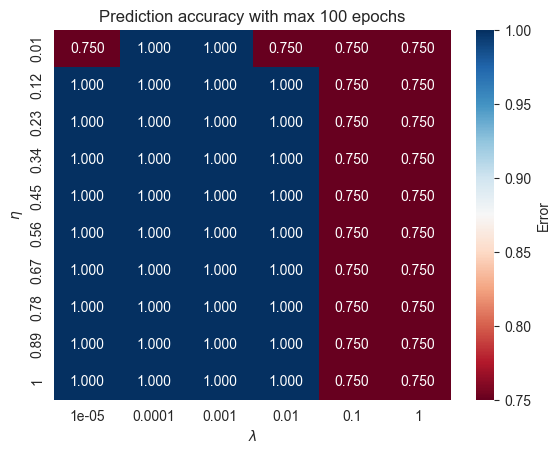

In [282]:
# Parameters
eta_vals = np.linspace(0.01, 1, 10)  # learning rate
lmbd_vals = np.logspace(-5, 0, 6)  # regularization rate
n_epochs = 100  # epochs for training
from sklearn.metrics import accuracy_score

# Iterate through parameters, train, save error to heatmap
accuracy = np.zeros((eta_vals.size, lmbd_vals.size))
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        for k in range(n_epochs):
            reset()
            train(eta, lmbd, max_epochs=1000, print_=False)
            prediction = predict(feed_forward(X)[-1])
            accuracy[i, j] = accuracy_score(target, prediction)

# Heatmap plot
sns.heatmap(
        accuracy,
        annot=True,
        fmt=".3f",
        xticklabels=[f"{lmbd:g}" for lmbd in lmbd_vals],
        yticklabels=[f"{eta:g}" for eta in eta_vals],
        cbar_kws={"label": "Error"},
        cmap="RdBu",
)

plt.title(f"Prediction accuracy with max {n_epochs} epochs")
plt.xlabel("$\lambda$")
plt.ylabel("$\eta$")

plt.show()